The notebook involves preprocessing license plate **_JSON_** data into threshold image for segmentation. \*Following implementations involves implementing CNN to recognize segmented images. 

_*not discussed here_ 

<br>

**INSTALLING ADDITIONAL DEPENDENCIES**

In [2]:
# install external libraries
!pip install mahotas

     |████████████████████████████████| 1.5MB 5.0MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.7-cp36-cp36m-linux_x86_64.whl size=4262386 sha256=063bbdccebe4ad331a725f700b688d3e008a9deb420fb8ae7ced543db72d9bf1
  Stored in directory: /root/.cache/pip/wheels/bb/0d/1e/c012eda7a9bb738a2fc531551681d680d31001abac3e14f3ed
Successfully built mahotas


In [0]:
# import libraries
import requests
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import urllib
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imutils
import json
import mahotas
import math
import cv2
from skimage.feature import hog
from skimage import exposure

In [9]:
# Input data files are available in the root directory.
import os
os.listdir()

['.config', 'Indian_Number_plates.json', 'sample_data']

**DOWNLOAD JSON DATA TO NUMPY ARRAY AND FILTER OUT THE NUMBER PLATE**

In [0]:
import json

# Read the data
data = pd.read_json('Indian_Number_plates.json', lines=True)
pd.set_option('display.max_colwidth', -1)

# Delete the empty column
del data['extras']

# Extract the points of the bounding boxes because thats what we want
data['points'] = data.apply(lambda row: row['annotation'][0]['points'], axis=1)

# And drop the rest of the annotation info
del data['annotation']

Images = []
Plates = []

def downloadTraining(df):

    for index, row in df.iterrows():

        # Get the image from the URL
        resp = urllib.request.urlopen(row[0])
        im = np.array(Image.open(resp))

        # We append the image to the training input array
        Images.append(im)  

        # Points of rectangle
        x_point_top = row[1][0]['x']*im.shape[1]
        y_point_top = row[1][0]['y']*im.shape[0]
        x_point_bot = row[1][1]['x']*im.shape[1]
        y_point_bot = row[1][1]['y']*im.shape[0]

        # Cut the plate from the image and use it as output
        carImage = Image.fromarray(im)
        plateImage = carImage.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
        Plates.append(np.array(plateImage))
        
downloadTraining(data)

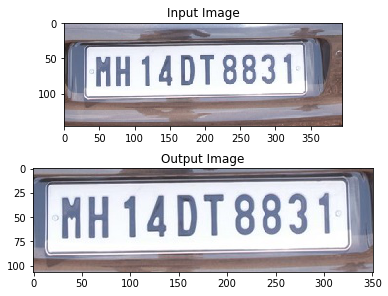

<Figure size 432x288 with 0 Axes>

In [7]:
# Create figure and axes
fig, ax = plt.subplots(2, 1, constrained_layout=True)
plt.figure()
for i in range(len(Images)):
  # Set title
  ax[0].set_title('Input Image')
  ax[1].set_title('Output Image')

  # Display the images
  ax[0].imshow(Images[i])
  ax[1].imshow(Plates[i])

plt.show()

**PREPROCESS DATA FOR SEGMENTATION**

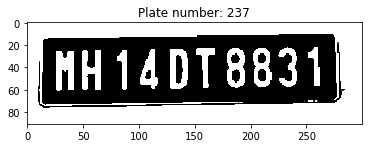

In [11]:
count = 1 # image count
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
for image in Plates:
  # Convert the coloured image into grayscale image
  image_resized=imutils.resize(image, width=300)
  try:
    # image from RGB to Grayscale
    image_gray=cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
  except:
    # image already in Grayscale
    image_gray = image_resized

  # Do thresholding
  image_thresh=image_gray
  T=mahotas.thresholding.otsu(image_gray) # will find an optimal value of T from the image
  image_thresh[image_thresh>T]=255 # This goes pixel by pixel if the pixel value of the thresh is greater than the optimal value then the color is white
  image_thresh[image_thresh<T]=0   # This goes pixel by pixel if the pixel value of the thresh is greater than the optimal value then the color is Black
  image_thresh = cv2.bitwise_not(image_thresh)

  # Perform dialation
  kernel = np.ones((1,1),np.uint8)
  image_eroded = cv2.erode(image_thresh,kernel,iterations = 5)
  image_eroded = cv2.morphologyEx(image_eroded, cv2.MORPH_OPEN, kernel, iterations = 1)
  # image_eroded = cv2.erode(image_eroded,kernel,iterations = 1)
  ax.set_title("Plate number: " + str(count))
  ax.imshow(image_eroded, cmap="gray")
  count = count + 1

**END OF NOTEBOOK**